In [5]:
%load_ext autoreload

In [6]:
import os
import sys
import random
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as T

sys.path.append('../..')

In [7]:
%autoreload 2
from fundus_extractor.utils.general import imshow

In [8]:
class ImageOutOfDistributionError(Exception):
    pass

In [9]:
def resize_image(image: torch.Tensor, image_resize_size: int) -> torch.Tensor:
    return T.functional.resize(image, (image_resize_size, image_resize_size))


def cut_image(image: torch.Tensor, threshold: float = 0.2, min_gray: float = 0.05)-> torch.Tensor:
    gray_image = T.functional.rgb_to_grayscale(image) / 255
    threshold *= torch.mean(gray_image).item()

    # Threshold the grayscale image
    binary_mask = (gray_image > threshold).float()[0]
    if binary_mask.shape[0] < 150 or binary_mask.shape[1] < 150:
        raise ImageOutOfDistributionError()

    cols = torch.mean(binary_mask, dim=0) > min_gray
    left, right = torch.min(torch.where(cols)[0]), torch.max(torch.where(cols)[0])

    rows = torch.mean(binary_mask, dim=1) > min_gray
    top, bottom = torch.min(torch.where(rows)[0]), torch.max(torch.where(rows)[0])

    # Crop the image based on the contour boundaries
    return image[:, top:bottom, left:right]


def pad_to_square(image: torch.Tensor) -> torch.Tensor:
    _, width, height = image.shape

    # Determine the maximum dimension
    max_dim = max(width, height)

    # Calculate the padding amounts
    pad_width = max_dim - width
    pad_height = max_dim - height

    # Calculate the padding values for top, bottom, left, and right
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Pad the image with zeros
    return torch.nn.functional.pad(image, (pad_top, pad_bottom, pad_left, pad_right))

In [10]:
labels_path = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/trainLabels.csv'
labels_df = pd.read_csv(labels_path)
labels_df[['id', 'left_or_right']] = labels_df['image'].str.split('_', expand=True)

# Drop the original "image" column
labels_df.drop('image', axis=1, inplace=True)
labels_df.head(10)

labels_df[(labels_df['id'] == '10') & (labels_df['left_or_right'] == 'left')]['level'].item()

0

### Random Test

/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/train/split_001/30625_left.jpeg


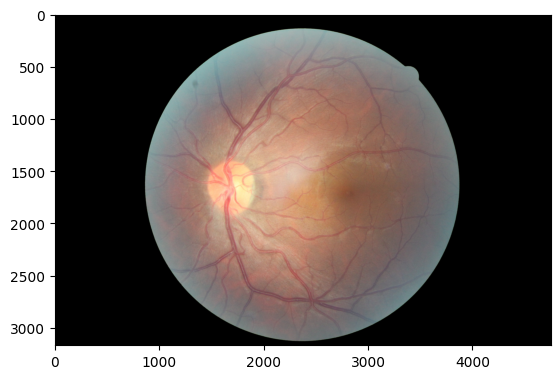

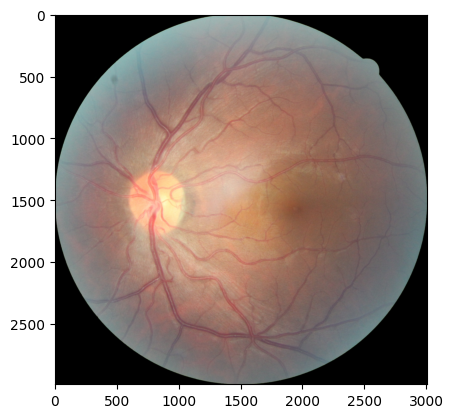

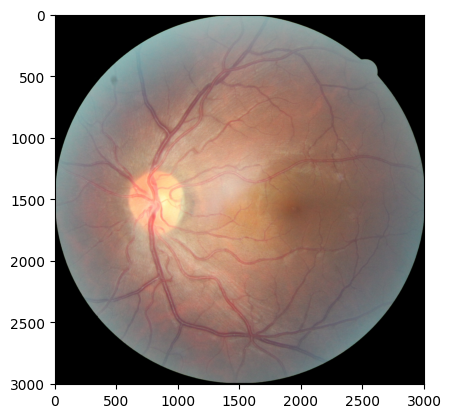

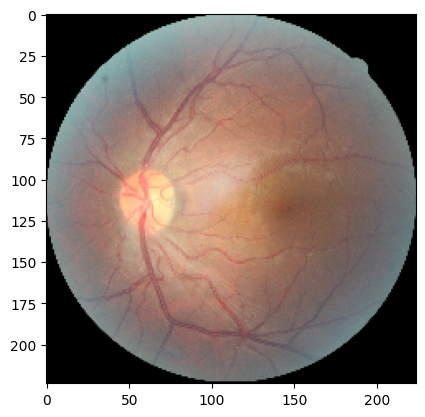

In [19]:
image_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/train/split_001'
image_file_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, image_file_name)
print(image_path)

image_raw = torchvision.io.read_image(image_path)
cropped_image = cut_image(image_raw)
padded_image = pad_to_square(cropped_image)
resized_image = resize_image(padded_image, 224)

imshow(image_raw)
imshow(cropped_image)
imshow(padded_image)
imshow(resized_image)

### Pipeline

In [52]:
image_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/train/split_001'
save_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/Fundus_01/data'

for image_file_name in tqdm(os.listdir(image_dir)):
    try:
        id, left_or_right = image_file_name.split('_')
        left_or_right = left_or_right.split('.')[0]
        class_label = labels_df[(labels_df['id'] == id) & (labels_df['left_or_right'] == left_or_right)]['level'].item()

        save_dir_image = os.path.join(save_dir, left_or_right, f'class_{class_label}')
        save_path_image = os.path.join(save_dir_image, f'{id}.jpeg')
        image_path = os.path.join(image_dir, image_file_name)
        os.makedirs(save_dir_image, exist_ok=True)

        image_raw = torchvision.io.read_image(image_path)
        cropped_image = cut_image(image_raw)
        padded_image = pad_to_square(cropped_image)
        resized_image = resize_image(padded_image, 224)
        torchvision.utils.save_image(resized_image / 255, save_path_image)
    except ImageOutOfDistributionError as e:
        imshow(torchvision.io.read_image(image_path))
        print(image_file_name)
    except Exception as e:
        print(image_file_name)
        print(e)


  0%|          | 0/35127 [00:00<?, ?it/s]/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 80%|███████▉  | 28010/35127 [49:54<10:14, 11.58it/s]  

not enough values to unpack (expected 2, got 1)


100%|██████████| 35127/35127 [1:02:55<00:00,  9.30it/s]
